Emma Klemets, Dec 2022   



Takashi asked me to quickly look at how B changes if we just scale the M_v parameter in the analytic dipole potential model. If this change looks like what we see, prehaps a small change of the cylotron field is what we are seeing when comparing the 2019 and 2022 data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
# from numpy import linalg as LA
import pandas as pd
# import seaborn as sns
from sympy.vector import CoordSys3D, gradient

import sys, os
sys.path.insert(1, '../../PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
# from stl import mesh
# from mpl_toolkits import mplot3d
# import bz2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
"""
Using the dipole model for the potential, calculates the B field for a given
region of points
Input:
    x_input, y_input, z_input: 1D arrays of points for each dimension of the region
Output:
    B_dipole: pd data frame with columes: ['x', 'y', 'z', 'B_x', 'B_y', 'B_z', 'B']
    - distances are in m, field is in T
"""
def DipoleFeild(Mv, x_input, y_input, z_input):
    #define a coordinate system to use
    R = CoordSys3D('F_{MSR}') 
    M = sp.symbols("M_v")
    x0,y0, z0 = sp.symbols(" x_0  y_0 z_0")
    x,y, z = sp.symbols(" x  y z")

    #the dipole function for the scalar potential
    Phi = sp.Function("\Phi_{dipole}")(M, R.x, x0,R.y, y0,R.z, z0 )
    Phi_funct = -M*(R.z-z0) / ((R.x-x0)**2 + (R.y-y0)**2 +(R.z-z0)**2)**(3/2)

    # The fit parameters from Takashi's work
    
    M_fit = Mv #-1.577 #T·m^3
    
    x0_fit = -16.03 #m
    y0_fit = -10.52 #m
    z0_fit = 0.531 #m 

    Phi_funct = Phi_funct.subs(M, M_fit).subs(x0, x0_fit).subs(y0, 
                            y0_fit).subs(z0, z0_fit) 

    # Phi_funct
    B = sp.Function("\\vec{B}_{dipole}")(R.x, R.y, R.z)
    #take the -gradient of the scalar potential
    B_funct = -1*gradient(Phi_funct).simplify()
    # display(sp.Eq(B, B_funct, evaluate=False))
    B_funct = B_funct.to_matrix(R)
    
    #convert each component back to a normal function to evalute numerically
    f_x = B_funct[0].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_x = sp.lambdify((x, y, z), f_x)

    f_y = B_funct[1].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_y = sp.lambdify((x, y, z), f_y)

    f_z = B_funct[2].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_z = sp.lambdify((x, y, z), f_z)
    
    # get a meshgrid of the region we actually want data for (in meters)
    xx, yy, zz = np.meshgrid(x_input, y_input, z_input, copy=True)

    #get the B field component in each position
    B_Xeval = B_x(xx, yy, zz)
    B_Yeval = B_y(xx, yy, zz)
    B_Zeval = B_z(xx, yy, zz)

    NT = np.product(xx.shape)
    # print(NT)

    #convert into a pandas data frame for use
    data = { #coords in m, B in T
        "x": np.reshape(xx,NT),
        "y": np.reshape(yy,NT),
        "z": np.reshape(zz,NT), 
        "B_x": np.reshape(B_Xeval,NT), 
        "B_y": np.reshape(B_Yeval,NT), 
        "B_z": np.reshape(B_Zeval,NT), 
        "B": np.reshape(np.sqrt(B_Xeval**2 + B_Yeval**2 + B_Zeval**2),NT), 
    }

    B_dipole = pd.DataFrame(data=data)
    return B_dipole

In [4]:
n = 80
#space where this model was made for ish, 
# DimX = np.linspace(-1, 1, n)
# DimY = np.linspace(-3, 1, n)
# DimZ = np.linspace(-.2, 2, n)

#guides region
DimX = np.linspace(-1, 1, n)
DimY = np.linspace(-2, 0, n)
DimZ = np.linspace(-0.6, 0.6, n)

""""
changing Mv by 1e-3 between now and then
M0 = -1.577 #T·m^3
"""

Mv_0 = -1.577 #T·m^3
#and use the analytic model to get the field for the given points
B_dipole_original = DipoleFeild(Mv_0, DimX, DimY, DimZ)

Mv = -1.577 - .2 #T·m^3
#and use the analytic model to get the field for the given points
B_dipole_change = DipoleFeild(Mv, DimX, DimY, DimZ)

In [5]:
df_compare = B_dipole_original.join(B_dipole_change, rsuffix='_22', how='outer')

df_compare = df_compare.where((df_compare['x']==df_compare['x_22']) & 
                                      (df_compare['y']==df_compare['y_22']) &
                                      (df_compare['z']==df_compare['z_22']))

df_compare = df_compare.drop(columns=['x_22', 'y_22', 'z_22'])

df_compare['dB_x'] = df_compare['B_x'] - df_compare['B_x_22'] 
df_compare['dB_y'] = df_compare['B_y'] - df_compare['B_y_22'] 
df_compare['dB_z'] = df_compare['B_z'] - df_compare['B_z_22'] 

#convert to cm for plotting
df_compare['x'] = df_compare['x']*100
df_compare['y'] = df_compare['y']*100
df_compare['z'] = df_compare['z']*100

# df_compare

[-100.          -97.46835443  -94.93670886  -92.40506329  -89.87341772
  -87.34177215  -84.81012658  -82.27848101  -79.74683544  -77.21518987
  -74.6835443   -72.15189873  -69.62025316  -67.08860759  -64.55696203
  -62.02531646  -59.49367089  -56.96202532  -54.43037975  -51.89873418
  -49.36708861  -46.83544304  -44.30379747  -41.7721519   -39.24050633
  -36.70886076  -34.17721519  -31.64556962  -29.11392405  -26.58227848
  -24.05063291  -21.51898734  -18.98734177  -16.4556962   -13.92405063
  -11.39240506   -8.86075949   -6.32911392   -3.79746835   -1.26582278
    1.26582278    3.79746835    6.32911392    8.86075949   11.39240506
   13.92405063   16.4556962    18.98734177   21.51898734   24.05063291
   26.58227848   29.11392405   31.64556962   34.17721519   36.70886076
   39.24050633   41.7721519    44.30379747   46.83544304   49.36708861
   51.89873418   54.43037975   56.96202532   59.49367089   62.02531646
   64.55696203   67.08860759   69.62025316   72.15189873   74.6835443
   77.2

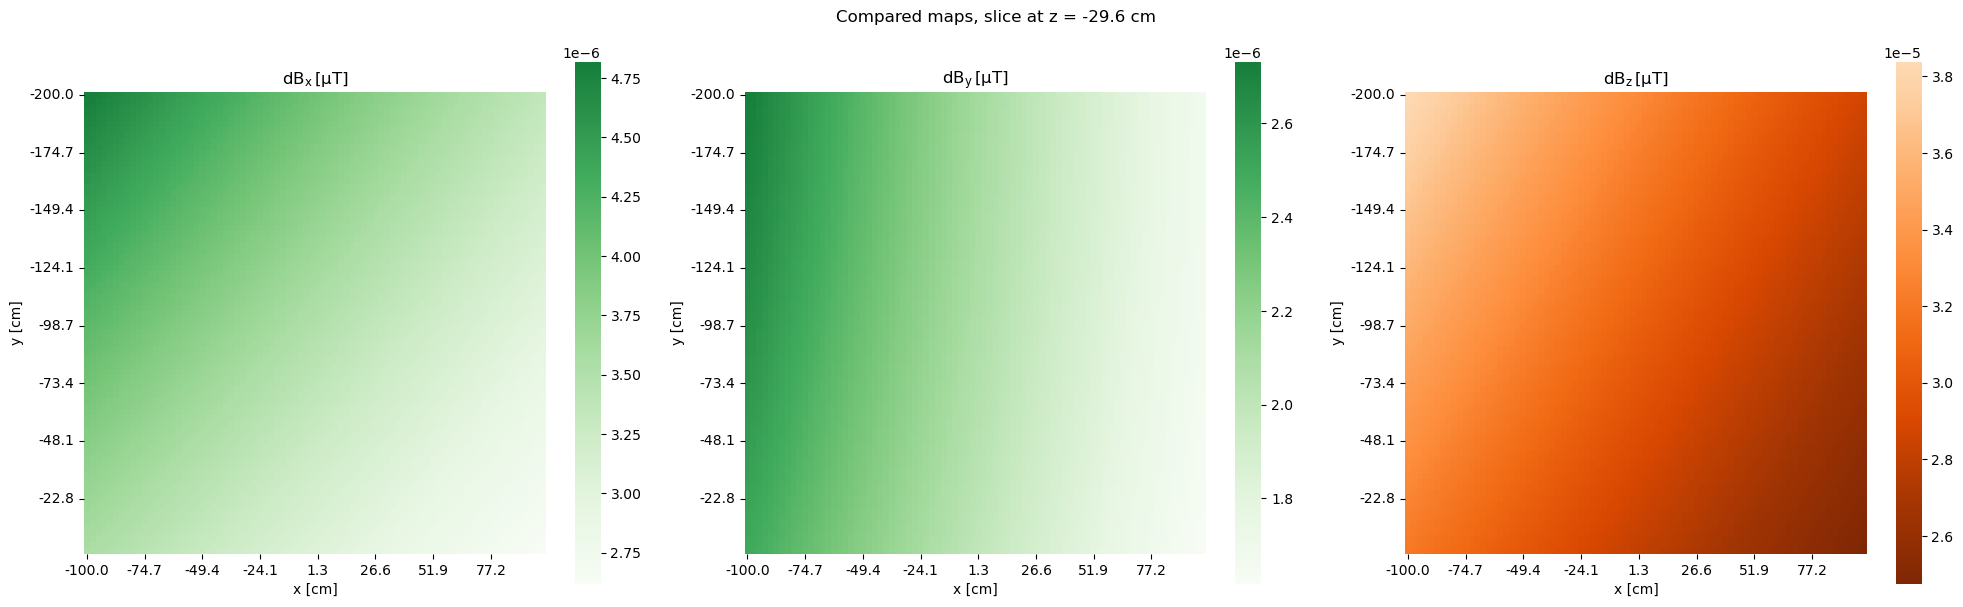

In [6]:
print(df_compare['x'].unique())
Xslice = df_compare['x'].unique()[50]
Zslice = df_compare['z'][20]

# limsA = np.array([[-42, 42], [-50, 50], [-50, 50]])
ppf.PlotComponentsSliceHeat(df_compare, slicer=[None, None, Zslice], 
                    Compare=True, fsize=(20,6), lims=None, title="Compared maps")
plt.show()

3.8782175139280746e-05 2.457948608430231e-05


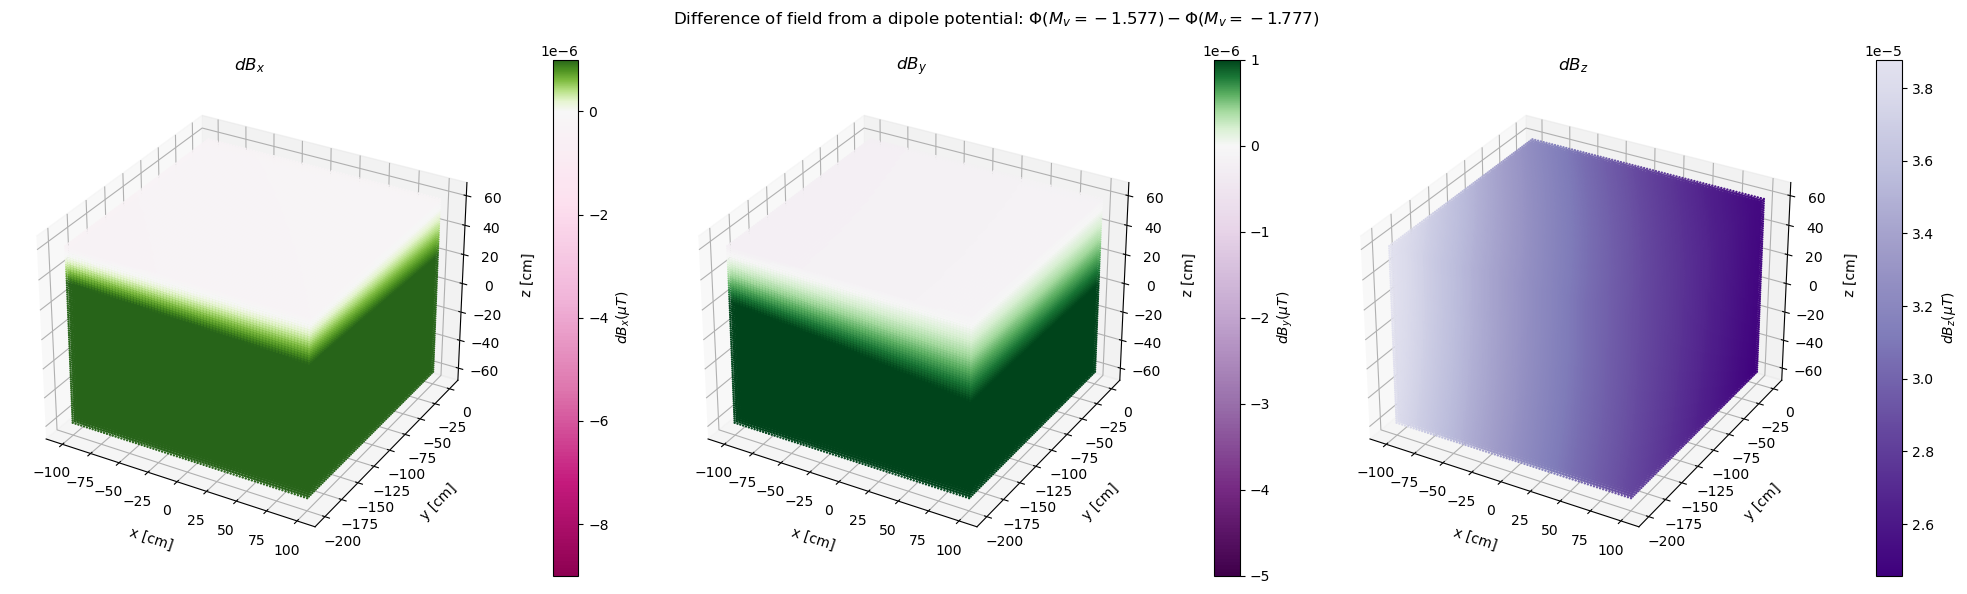

In [7]:
titleS = f"Difference of field from a dipole potential: $\Phi(M_v={Mv_0}) - \Phi(M_v={Mv:.4})$"
limsA = np.array([[-.9, .1], [-.5, .1], [-2, 0.1]])*1e-5

ppf.PlotComponents(df_compare, Compare=True, lims=limsA, title=titleS, Sample=None, limScale=1e-9)
# plt.savefig('plots/compare_3C.png', bbox_inches='tight')
plt.show()